In [1]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LassoCV
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import seaborn as sns
from sklearn import metrics

# Load in the data
data = pd.read_csv("weatherAUS.csv")

In [2]:
# Look at first 5 rows
print(data.head())
print(data.info())
print(data.describe())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

In [3]:
print(data['Sunshine'].isna().sum())
print(data['Evaporation'].isna().sum())

69835
62790


C:\Users\matth\AppData\Local\Temp\ipykernel_17220\3831415896.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<Axes: >

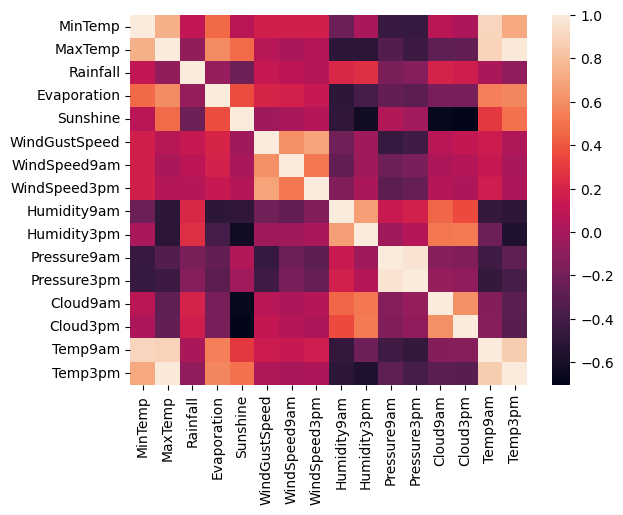

In [4]:
# Heat map for the correlation of all numerical features
sns.heatmap(data.corr())

## <b> EDA </b>
Some columns have a lot of missing values and some with high correlation. With this, we can remove some of features that would otherwise provide minimal input to our model. Some further input is given below with lasso.

In [5]:
# Lasso stuff to find best features

dataraw = data.drop(columns=["Date", "Location", "WindGustDir", "WindDir9am", "WindDir3pm"])

# Drop null values
dataraw = dataraw.dropna()

scale = StandardScaler()
labelenc = LabelEncoder()

# Encoding and Normalizing
yraw = dataraw[['RainTomorrow']]

xraw = dataraw.drop(['RainTomorrow'], axis=1)

xraw.loc[data['RainToday'] == 'Yes', 'RainToday'] = 1
xraw.loc[data['RainToday'] == 'No', 'RainToday'] = 0

# Normalize x data 
xscale = scale.fit_transform(xraw)

Xraw = torch.FloatTensor(xscale)
# Encode the response variable
yraw = labelenc.fit_transform(yraw)

# Lasso
lasso = LassoCV()
lasso.fit(xraw, yraw)
feature_importance = pd.Series(lasso.coef_, index=xraw.columns).sort_values(ascending=False)
print(feature_importance)

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RainToday        0.049800
Pressure9am      0.014006
MaxTemp          0.008664
Humidity3pm      0.008316
WindGustSpeed    0.008182
Cloud3pm         0.004366
Rainfall         0.003343
Evaporation      0.000817
Temp3pm          0.000000
Temp9am         -0.000000
WindSpeed9am    -0.000449
Humidity9am     -0.000695
Cloud9am        -0.004816
WindSpeed3pm    -0.005304
MinTemp         -0.008723
Pressure3pm     -0.022849
Sunshine        -0.026712
dtype: float64


## <b> Feature selection </b>
By using Lasso regression we can find weights associated with each feature. In this case, the further away each weight is from 0, the better the feature. As such we will choose a subset of the ones that are furthest from zero. <br>
<b> Generally: </b> <br>
While this dataset has a modest amount of features, others can contain more features. As with any dataset, there may be some redundent features or ones that are irrelivant to what is trying to be proven. As such, by selecting features that provide the most information. As well, be doing so we can generalize our model by reducing the additional complexity that comes with additional features. This makes models faster to compute and more generalizable.

In [6]:
# Keep all of these columns, remove the rest
# These columns were chosen from Lasso (see before)
columns_to_keep = ['RainToday', 'Pressure9am', 'MaxTemp', 'Humidity3pm', 'WindGustSpeed', 'Cloud3pm', 'Rainfall', 'Sunshine', 'Pressure3pm', 'RainTomorrow']
data = data.drop(columns=data.columns.difference(columns_to_keep))

# Drop null values
data = data.dropna()

data.head()

,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Pressure3pm,Cloud3pm,RainToday,RainTomorrow
6049,35.2,0.0,12.3,48.0,13.0,1006.3,1004.4,5.0,No,No
6050,28.9,0.0,13.0,37.0,8.0,1012.9,1012.1,1.0,No,No
6052,37.6,0.0,10.6,46.0,22.0,1012.3,1009.2,6.0,No,No
6053,38.4,0.0,12.2,31.0,22.0,1012.7,1009.1,5.0,No,No
6054,41.0,0.0,8.4,35.0,15.0,1010.7,1007.4,6.0,No,No


In [7]:
data.corr()

C:\Users\matth\AppData\Local\Temp\ipykernel_17220\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Pressure3pm,Cloud3pm
MaxTemp,1.000000,-0.044169,0.463770,0.057039,-0.450102,-0.360749,-0.458268,-0.257218
Rainfall,-0.044169,1.000000,-0.234711,0.115846,0.262122,-0.177939,-0.142956,0.179185
Sunshine,0.463770,-0.234711,1.000000,-0.040505,-0.636652,0.043849,-0.018501,-0.702890
WindGustSpeed,0.057039,0.115846,-0.040505,1.000000,-0.045632,-0.435554,-0.390613,0.124630
Humidity3pm,-0.450102,0.262122,-0.636652,-0.045632,1.000000,-0.068442,0.017954,0.519514
Pressure9am,-0.360749,-0.177939,0.043849,-0.435554,-0.068442,1.000000,0.962461,-0.169177
Pressure3pm,-0.458268,-0.142956,-0.018501,-0.390613,0.017954,0.962461,1.000000,-0.106885
Cloud3pm,-0.257218,0.179185,-0.702890,0.124630,0.519514,-0.169177,-0.106885,1.000000


In [8]:
# We want to keep this value, as it is a great feature
data.loc[data['RainToday'] == 'Yes', 'RainToday'] = 1
data.loc[data['RainToday'] == 'No', 'RainToday'] = 0

In [9]:
# Encoding and Normalizing
scale = StandardScaler()
labelenc = LabelEncoder()

y = data[['RainTomorrow']]

x = data.drop(['RainTomorrow'], axis=1)

# Normalize x data 
xscale = scale.fit_transform(x)

X = torch.FloatTensor(xscale)
# Encode the response variable
y = labelenc.fit_transform(y)


# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = torch.LongTensor(y_train)

c:\Users\matth\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# The nn
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.model = nn.Sequential(OrderedDict([ # The model
            # Input layer
            ('lin1', nn.Linear(input_size, hidden_size)),
            # activation function
            ('relu1', nn.ReLU()),
            # Hidden layer
            ('lin2', nn.Linear(hidden_size, 1)),
            # Output layer
            ('sig1', nn.Sigmoid())
        ]))

    # Passing data through the network
    def forward(self, x):
        return self.model(x)



# Set seed for consistent results
torch.manual_seed(42)

# Get the size of the input
input_size = x_train.shape[1]
# How many neurons are in the hidden layer
hidden_size = 20

# Make the model
clf = Model(input_size, hidden_size)

# Optimizer
opt = optim.Adam(clf.parameters(), lr=0.001)

# Binary classification, did it rain tomorrow, yes or no
loss_fn = nn.BCELoss()

In [11]:
# Training
for epoch in range(20):
    # Predict
    yhat = clf(x_train)

    # reshape the prediction
    yhat = yhat.squeeze(1)

    # Calculate the loss
    loss = loss_fn(yhat, y_train.float())
    
    # Backpropagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print(f'Epoch [{epoch + 1}/{20}], Loss: {loss}')


Epoch [1/20], Loss: 0.6838440299034119
Epoch [2/20], Loss: 0.6807156801223755
Epoch [3/20], Loss: 0.677604079246521
Epoch [4/20], Loss: 0.6745091080665588
Epoch [5/20], Loss: 0.6714311838150024
Epoch [6/20], Loss: 0.6683706641197205
Epoch [7/20], Loss: 0.6653284430503845
Epoch [8/20], Loss: 0.6623043417930603
Epoch [9/20], Loss: 0.6592985391616821
Epoch [10/20], Loss: 0.6563111543655396
Epoch [11/20], Loss: 0.6533414721488953
Epoch [12/20], Loss: 0.6503897905349731
Epoch [13/20], Loss: 0.647455096244812
Epoch [14/20], Loss: 0.644537627696991
Epoch [15/20], Loss: 0.6416371464729309
Epoch [16/20], Loss: 0.6387535929679871
Epoch [17/20], Loss: 0.6358861923217773
Epoch [18/20], Loss: 0.6330345273017883
Epoch [19/20], Loss: 0.6301978826522827
Epoch [20/20], Loss: 0.6273758411407471


In [12]:
def printStats(predicitons, reals):
    # Get the total amount of predictions
    total_samples = len(reals)

    # convert the predictions of the model to classifications
    accuracy = predicitons.ge(0.5)
    # Reshape the array to get the accuracy
    accuracy = accuracy.int().reshape(1, -1)

    # Format the test set for the comparison
    y_test_tensor = torch.tensor(reals)

    # Print the accuracy
    # See the accuracy
    print(f'Accuracy: {((accuracy == y_test_tensor).sum() / total_samples).item()}')
    # print(((accuracy == y_test_tensor).sum() / total_samples).item().dtype)
    y_test_tensor = y_test_tensor.reshape(1, -1)
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_test_tensor.view(-1).numpy(), accuracy.view(-1).numpy()))
    return (((accuracy == y_test_tensor).sum() / total_samples).item())

In [13]:
# Put the model into evauluation mode
clf.eval()

# Test on the test set
yhat_test = clf(x_test)

printStats(yhat_test, y_test)

Accuracy: 0.7776188254356384
Confusion matrix:
[[14128    17]
 [ 4025     6]]


0.7776188254356384

## <b> Hyperparameter tuning </b>
Now that we have seen the results of the network with a single hidden layer with 20 neurons, lets change various parameters to see the changes.

In [14]:
hyperparameters = {
    'hidden_size': [2, 5, 10, 20, 50],
    'learning_rate': [0.5, 0.1, 0.01, 0.001, 0.0001],
    'epochs': [5, 10, 20, 50, 100, 200, 500]
}

In [15]:
size = 0
learn = 0
epoches = 0
bests = {}
vals = {}
for k in hyperparameters:
    bests[k] = 0
    for v in hyperparameters[k]:
        
        if k == 'hidden_size':
            size = v
            learn = 0.001
            epoches = 20
        elif k == 'learning_rate':
            size = 20
            learn = v
            epoches = 20
        elif k == 'epochs':
            size = 20
            learn = 0.001
            epoches = v

        clf = Model(x_train.shape[1], size)
        opt = optim.Adam(clf.parameters(), lr=0.003)
        loss_fn = nn.BCELoss()

        for epoch in range(epoches):
            yhat = clf(x_train)

            # reshape the prediction
            yhat = yhat.squeeze(1)

            # Calculate the loss
            loss = loss_fn(yhat, y_train.float())
            
            # Backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        print(f'Paratmeters: Size: {size}, Learn {learn}, Epoches {epoches} \n Result: Loss: {loss}')
        clf.eval()
        val = printStats(clf(x_test), y_test)
        print()
        if val > bests[k]:
            bests[k] = val

print(bests)

Paratmeters: Size: 2, Learn 0.001, Epoches 20 
 Result: Loss: 0.5415947437286377
Accuracy: 0.7782240509986877
Confusion matrix:
[[14145     0]
 [ 4031     0]]

Paratmeters: Size: 5, Learn 0.001, Epoches 20 
 Result: Loss: 0.5842729210853577
Accuracy: 0.7782240509986877
Confusion matrix:
[[14145     0]
 [ 4031     0]]

Paratmeters: Size: 10, Learn 0.001, Epoches 20 
 Result: Loss: 0.5445820093154907


Accuracy: 0.8159661293029785
Confusion matrix:
[[13957   188]
 [ 3157   874]]

Paratmeters: Size: 20, Learn 0.001, Epoches 20 
 Result: Loss: 0.49456197023391724
Accuracy: 0.8176166415214539
Confusion matrix:
[[13827   318]
 [ 2997  1034]]

Paratmeters: Size: 50, Learn 0.001, Epoches 20 
 Result: Loss: 0.47085481882095337
Accuracy: 0.8128851056098938
Confusion matrix:
[[13313   832]
 [ 2569  1462]]

Paratmeters: Size: 20, Learn 0.5, Epoches 20 
 Result: Loss: 0.47032618522644043
Accuracy: 0.8300505876541138
Confusion matrix:
[[12937  1208]
 [ 1881  2150]]

Paratmeters: Size: 20, Learn 0.1, Epoches 20 
 Result: Loss: 0.6261359453201294
Accuracy: 0.7578125
Confusion matrix:
[[10702  3443]
 [  959  3072]]

Paratmeters: Size: 20, Learn 0.01, Epoches 20 
 Result: Loss: 0.5161843299865723
Accuracy: 0.8319762349128723
Confusion matrix:
[[13378   767]
 [ 2287  1744]]

Paratmeters: Size: 20, Learn 0.001, Epoches 20 
 Result: Loss: 0.6230173707008362
Accuracy: 0.786861777305603
Confusion matrix:

## <b> Results </b>
Knowing that there is only one set of results its hard to make a conclusion about how they change between runs. However, generally, from what I have witnessed, the amount of neurons in the hidden layer does not appear to affect the classification in a dramatic way. The learning rate has varying results seeming to oscillate. The amount of epoches is the only parameter out of the three that has a constant increase on the performance of the model. Increasing the number of epoches increases the accuracy. <br>
Using a more ideal subset, we can get an accuracy of 85% or about a 3-4% increase, which is pretty good!

In [16]:
# running on best subset of hyperparameters
hidden_size = 20
clf = Model(input_size, hidden_size)

# Seed
torch.manual_seed(42)

# Optimizer
opt = optim.Adam(clf.parameters(), lr=0.01)

# Binary classification, did it rain tomorrow, yes or no
loss_fn = nn.BCELoss()

# Training
for epoch in range(200):
    # Predict
    yhat = clf(x_train)

    # reshape the prediction
    yhat = yhat.squeeze(1)

    # Calculate the loss
    loss = loss_fn(yhat, y_train.float())
    
    # Backpropagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print(f'Epoch [{epoch + 1}/{20}], Loss: {loss}')

printStats(clf(x_test), y_test)

Epoch [1/20], Loss: 0.7702599167823792
Epoch [2/20], Loss: 0.7400627136230469
Epoch [3/20], Loss: 0.7123486399650574
Epoch [4/20], Loss: 0.6867501735687256
Epoch [5/20], Loss: 0.6629327535629272
Epoch [6/20], Loss: 0.6405813694000244
Epoch [7/20], Loss: 0.6194026470184326
Epoch [8/20], Loss: 0.5991455316543579
Epoch [9/20], Loss: 0.5796284675598145
Epoch [10/20], Loss: 0.5607244372367859
Epoch [11/20], Loss: 0.5423573851585388
Epoch [12/20], Loss: 0.5244921445846558
Epoch [13/20], Loss: 0.507156491279602
Epoch [14/20], Loss: 0.4904307425022125
Epoch [15/20], Loss: 0.47441935539245605
Epoch [16/20], Loss: 0.4592622220516205
Epoch [17/20], Loss: 0.44507312774658203
Epoch [18/20], Loss: 0.4319545328617096
Epoch [19/20], Loss: 0.4199884533882141
Epoch [20/20], Loss: 0.40921851992607117
Epoch [21/20], Loss: 0.3996589779853821
Epoch [22/20], Loss: 0.39128926396369934
Epoch [23/20], Loss: 0.3840568959712982
Epoch [24/20], Loss: 0.377882719039917
Epoch [25/20], Loss: 0.3726724684238434
Epoch [

0.8554137349128723

## <b> One last thing we can try is using a different model with more than one hidden layer</b>

In [17]:
# Another model with an additional hidden layer
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model2, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(input_size, hidden_size)),
            ('relu1', nn.ReLU()),
            ('lin2', nn.Linear(hidden_size, hidden_size)),

            # Additional layer
            ('relu2', nn.ReLU()),
            ('lin3', nn.Linear(hidden_size, 1)),

            ('sig1', nn.Sigmoid())
        ]))


    def forward(self, x):
        return self.model(x)
    

model2 = Model2(input_size, hidden_size)

# Training
for epoch in range(20):
    # Predict
    yhat = clf(x_train)

    # reshape the prediction
    yhat = yhat.squeeze(1)

    # Calculate the loss
    loss = loss_fn(yhat, y_train.float())
    
    # Backpropagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print(f'Epoch [{epoch + 1}/{20}], Loss: {loss}')


# Put the model into evauluation mode
model2.eval()

# Test on the test set
yhat_test = clf(x_test)

# Get the total amount of predictions
total_samples = len(y_test)

# convert the predictions of the model to classifications
accuracy = yhat_test.ge(0.5)
# Reshape the array to get the accuracy
accuracy = accuracy.int().reshape(1, -1)

# Format the test set for the comparison
y_test_tensor = torch.tensor(y_test)

# Print the accuracy
# See the accuracy
print(f'Accuracy: {((accuracy == y_test_tensor).sum() / total_samples).item()}')
y_test_tensor = y_test_tensor.reshape(1, -1)
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test_tensor.view(-1).numpy(), accuracy.view(-1).numpy()))


Epoch [1/20], Loss: 0.3265420198440552
Epoch [2/20], Loss: 0.3265167772769928
Epoch [3/20], Loss: 0.3264913558959961
Epoch [4/20], Loss: 0.3264656960964203
Epoch [5/20], Loss: 0.32644033432006836
Epoch [6/20], Loss: 0.32641491293907166
Epoch [7/20], Loss: 0.32639017701148987
Epoch [8/20], Loss: 0.3263658583164215
Epoch [9/20], Loss: 0.32634207606315613
Epoch [10/20], Loss: 0.3263173997402191
Epoch [11/20], Loss: 0.3262920379638672
Epoch [12/20], Loss: 0.3262667953968048
Epoch [13/20], Loss: 0.3262424170970917
Epoch [14/20], Loss: 0.32621875405311584
Epoch [15/20], Loss: 0.3261961340904236
Epoch [16/20], Loss: 0.3261745870113373
Epoch [17/20], Loss: 0.32615330815315247
Epoch [18/20], Loss: 0.32613202929496765
Epoch [19/20], Loss: 0.32611095905303955
Epoch [20/20], Loss: 0.3260897696018219
Accuracy: 0.8554137349128723
Confusion matrix:
[[13321   824]
 [ 1804  2227]]


## <b> Hyperparameters </b> <br>

In [18]:
size = 0
learn = 0
epoches = 0
bests = {}
vals = {}
for k in hyperparameters:
    bests[k] = 0
    for v in hyperparameters[k]:
        
        if k == 'hidden_size':
            size = v
            learn = 0.001
            epoches = 20
        elif k == 'learning_rate':
            size = 20
            learn = v
            epoches = 20
        elif k == 'epochs':
            size = 20
            learn = 0.001
            epoches = v

        clf = Model2(x_train.shape[1], size)
        opt = optim.Adam(clf.parameters(), lr=0.003)
        loss_fn = nn.BCELoss()

        for epoch in range(epoches):
            yhat = clf(x_train)

            # reshape the prediction
            yhat = yhat.squeeze(1)

            # Calculate the loss
            loss = loss_fn(yhat, y_train.float())
            
            # Backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        print(f'Parameters: Size: {size}, Learn {learn}, Epoches {epoches} \n Result: Loss: {loss}')
        clf.eval()
        val = printStats(clf(x_test), y_test)
        print()
        if val > bests[k]:
            bests[k] = val

print(bests)

Parameters: Size: 2, Learn 0.001, Epoches 20 
 Result: Loss: 0.5862046480178833
Accuracy: 0.7784991264343262
Confusion matrix:
[[14144     1]
 [ 4025     6]]

Parameters: Size: 5, Learn 0.001, Epoches 20 
 Result: Loss: 0.6395537853240967
Accuracy: 0.7789942622184753
Confusion matrix:
[[14137     8]
 [ 4009    22]]

Parameters: Size: 10, Learn 0.001, Epoches 20 
 Result: Loss: 0.6110259890556335
Accuracy: 0.7852662801742554
Confusion matrix:
[[14137     8]
 [ 3895   136]]

Parameters: Size: 20, Learn 0.001, Epoches 20 
 Result: Loss: 0.4761533737182617
Accuracy: 0.814205527305603
Confusion matrix:
[[13839   306]
 [ 3071   960]]

Parameters: Size: 50, Learn 0.001, Epoches 20 
 Result: Loss: 0.4136991798877716
Accuracy: 0.8189370632171631
Confusion matrix:
[[13858   287]
 [ 3004  1027]]

Parameters: Size: 20, Learn 0.5, Epoches 20 
 Result: Loss: 0.515352725982666
Accuracy: 0.8288402557373047
Confusion matrix:
[[13482   663]
 [ 2448  1583]]

Parameters: Size: 20, Learn 0.1, Epoches 20 
 

In [19]:
# Subset parameters
# running on best subset of hyperparameters
hidden_size = 50
clf = Model2(input_size, hidden_size)

# Seed
torch.manual_seed(42)

# Optimizer
opt = optim.Adam(clf.parameters(), lr=0.01)

# Binary classification, did it rain tomorrow, yes or no
loss_fn = nn.BCELoss()

# Training
for epoch in range(200):
    # Predict
    yhat = clf(x_train)

    # reshape the prediction
    yhat = yhat.squeeze(1)

    # Calculate the loss
    loss = loss_fn(yhat, y_train.float())
    
    # Backpropagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print(f'Epoch [{epoch + 1}/{20}], Loss: {loss}')

printStats(clf(x_test), y_test)

Epoch [1/20], Loss: 0.68227219581604
Epoch [2/20], Loss: 0.6287727952003479
Epoch [3/20], Loss: 0.5766676664352417
Epoch [4/20], Loss: 0.5214806795120239
Epoch [5/20], Loss: 0.46597298979759216
Epoch [6/20], Loss: 0.41589394211769104
Epoch [7/20], Loss: 0.3788703382015228
Epoch [8/20], Loss: 0.3599550127983093
Epoch [9/20], Loss: 0.3578850328922272
Epoch [10/20], Loss: 0.36462292075157166
Epoch [11/20], Loss: 0.3718043565750122
Epoch [12/20], Loss: 0.3754693865776062
Epoch [13/20], Loss: 0.3748303949832916
Epoch [14/20], Loss: 0.370636522769928
Epoch [15/20], Loss: 0.3644161522388458
Epoch [16/20], Loss: 0.35808995366096497
Epoch [17/20], Loss: 0.35340526700019836
Epoch [18/20], Loss: 0.35102975368499756
Epoch [19/20], Loss: 0.3502759635448456
Epoch [20/20], Loss: 0.3498873710632324
Epoch [21/20], Loss: 0.3491192162036896
Epoch [22/20], Loss: 0.34781327843666077
Epoch [23/20], Loss: 0.34596771001815796
Epoch [24/20], Loss: 0.34371793270111084
Epoch [25/20], Loss: 0.3414458930492401
Epo

0.8554137349128723

## <b> Results </b> <br>
Comparing the result of the additional hidden layer to our model with only one, we see no change. While the loss rate does decrease with each epoch, there a few reasons why the accuracy doesn't change. It can only learn so much from the training data it's given, the amount of information the network is gaining is almost negligible therefore giving almost zero improvement, or there could be some overfitting in the model. 

## <b> Report </b> <br>
Neural networks, at least in 2023, are the the some of the most prominent models that appear to the public. While not the best to solve every problem, they are used for higher complexity problems. This first part of the project which goes into a simple neural network gave me great insights into how I can go about making my own. While the dataset given was not the worst in terms of how much preprocessing there was to perform, the lack of attempting to work with my own data will have to be discovered elsewhere. <br>
##### EDA <br>
Looking at a correlation of the features and removing rows with missing values was a simpiler approach to preprocessing the data. Some other actions could be to attempt to replace missing values with a default where applicable. This would give for more data to work with which may or may not increase the accuracy of the model. <br>
##### Feature reduction <br>
Using what was given, I used lasso to do some feature reduction. While my computer started smoking when working with the entire dataset, reducing the dataset's features to about half of what is was before seemed to fix the problem. While the features I used are some of the most prominent ones, there were some more that could have been used, however as stated I opted to reduce the stress on my computer. <br>
##### Model creation <br>
The first model follow as stated is an input layer, followed by a hidden layer, then the output layer. There are a ton of different options for the specifics of a given layer, however I opted for a Linear approach given the context of the project. Using ReLU as its a staple accross Machine learning and sigmoid to give a probablity from which I then chose to have 0.5 or 50% be the minimum to guess a certain way. As well, the loss function I used was the binary classifiction, because, well, it either is or is not raining tomorrow, there is no other option.<br>
##### Model training <br>
Using a train test split defined before hand, and normalized beforehand, that was going to be what every model trained on. Using that training data, we can then have the model predict, calculate the difference between the predicted and true result, then update our model with that information for the next epoch. <br>
##### Model evaluation <br>
Using the test split, I then tested the accuracy of the models. As well, I made a confusion matrix to see what types of classifications it got wrong. <br>
##### Improvements <br>
Some of the improvements have been stated: better preprocessing, exploring other options to use inside of the neural network layers/activation functions, and kfold CV. Some other options could be to use a different model entirely, perhaps logisitc regression does just as good a job. 